<a href="https://colab.research.google.com/github/spaceBearAmadeus/spaceBearAmadeus/blob/main/NavVisualizations(Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, DataFrame

In [ ]:
'''
CRISP DM Method -

Barry-Business Understanding
Drove-Data Understanding
Directly to the - Data Preperation
Medical - Modeling 
Emergency - Evaluation
Department - Deployment
'''

'\nCRISP DM Method -\n\nBarry-Business Understanding\nDrove-Data Understanding\nDirectly to the - Data Preperation\nMedical - Modeling \nEmergency - Evaluation\nDepartment - Deployment\n'

##1. Business Understanding

*   Forecasting Transactions
*   Likely regression
*   Data for 3 years
*   Advised data quality is okay

##2. Data Understanding

In [ ]:
import pandas as pd 
import typing 

In [ ]:
rose = SparkSession.builder.master("local[*]").getOrCreate()
rose.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

In [ ]:
def choose_and_load_csv(file_name:str):
  df = pd.read_csv(f"{file_name}.csv")
  return df 

df_insurance = choose_and_load_csv("insurance")

df_students = choose_and_load_csv("student-por")

df_journal = choose_and_load_csv("journal_august_21_22")

In [ ]:
df_insurance.isnull().sum(),
df_students.isnull().sum(),
df_journal.isnull().sum()

entry         0
entry_date    0
dtype: int64

In [ ]:
'''#perhaps we can use case whens to label and categorical values that are binary, such 
that, case when df4['smoker'] = 'yes' then 1 else 0'''

def create_df_report_cols(spark:SparkSession, file_name:str)-> DataFrame:
  def read_load(spark:SparkSession, file_name:str)-> DataFrame:
    df = rose.read.format('csv')\
                  .option('header', 'true')\
                  .option('inferSchema', 'true')\
                  .load(f'{file_name}.csv')
    return df

  def select_items(spark:SparkSession, df:DataFrame, col:str):
    #create temp view to traverse sql
    df.createOrReplaceTempView("dataframe")
    df = spark.sql(f"select {col}, count({col}) from dataframe group by {col}")
    df.show()
    return df
  
  df = read_load(spark, file_name)
  #for cols in df.columns:
  #  print(cols)
  #  x = select_items(spark, df, cols)
  #return x 
  return df 

ins_df = create_df_report_cols(rose, "insurance")

journal_df = create_df_report_cols(rose, "journal_august_21_22")

'''df from a csv within the directory, then create a temp view with placeholder name from
that df, then executed a sql query to select the distinct values within each col, and then 
their count. I used a formatted string for the second child function's arg, such that we can 
iterate on the actual return statement of the function.  I then used a for loop to iterate 
over each item(col) in df.columns(which itself returns as a list!)'''


"df from a csv within the directory, then create a temp view with placeholder name from\nthat df, then executed a sql query to select the distinct values within each col, and then \ntheir count. I used a formatted string for the second child function's arg, such that we can \niterate on the actual return statement of the function.  I then used a for loop to iterate \nover each item(col) in df.columns(which itself returns as a list!)"

In [ ]:
'''we are going to use case when statements to convert any categorical data that is binary in 
nature into integer form, so: sex, smoker will be 0 for no, 1 for yes'''

journal_df 

entry,entry_date
Consider the amaz...,2022-08-24 00:56:...
so in the folder ...,2022-08-24 11:28:...
more questions fo...,2022-08-24 12:21:...
"So, I am learning...",2022-08-24 12:26:...
consider the fact...,2022-08-25 22:27:...
this is the actua...,2022-08-25 23:13:...
amazing things on...,2022-08-26 11:39:...
my goal for today...,2022-08-26 11:39:...
Let's consider a ...,2022-08-26 11:44:...
so in a left oute...,2022-08-26 11:49:...


In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textblob import TextBlob


In [ ]:
from pyspark.sql.functions import col

In [ ]:
journ_df = journal_df.toPandas()

def add_subj_and_pol(df):
  def get_subjectivity(df):
    subjectivity_list = []
    for entry in journ_df['entry']:
      subjectivity_list.append((TextBlob(entry).sentiment.subjectivity)*100)
    return subjectivity_list

  def get_polarity(df):
    polarity_list = []
    for entry in journ_df['entry']:
      polarity_list.append((TextBlob(entry).sentiment.polarity)*100)
    return polarity_list

  subjectivity_list = get_subjectivity(df)
  polarity_list = get_polarity(df)
  df['entry_subjectivity'] = subjectivity_list
  df['entry_polarity'] = polarity_list
  return df 

    

journal_with_sentiments_df = add_subj_and_pol(journ_df)

journal_with_sentiments_df

,entry,entry_date,entry_subjectivity,entry_polarity
0,Consider the amazing scope of python. I am imp...,2022-08-24 00:56:34.575409,50.000000,35.000000
1,so in the folder 'SPARK_practice' we are imple...,2022-08-24 11:28:58.871384,73.750000,58.125000
2,"more questions for Vinny: first, what is the b...",2022-08-24 12:21:03.607803,23.958333,18.750000
3,"So, I am learning more in depth about Java and...",2022-08-24 12:26:23.632707,50.000000,50.000000
4,consider the fact that when we say if isinstan...,2022-08-25 22:27:02.108078,66.875000,6.250000
5,this is the actual path of THIS file: print(os...,2022-08-25 23:13:06.757321,13.809524,-2.380952
6,amazing things on the horizon: after consultin...,2022-08-26 11:39:05.559125,90.000000,60.000000
7,my goal for today is to do more with SQL and l...,2022-08-26 11:39:53.693929,50.000000,50.000000
8,Let's consider a common scenario of two tables...,2022-08-26 11:44:35.457006,53.240741,-7.777778
9,"so in a left outer join, the rows are still jo...",2022-08-26 11:49:16.816641,26.339286,6.964286


In [ ]:
'''here we added three cols and did polarity(external stimuli to your brain) cut by
the subjectivity or "padding" where you take someone's words with "a grain of salt'''

journal_with_sentiments_df['sentiment'] = journal_with_sentiments_df.entry_polarity / journal_with_sentiments_df.entry_subjectivity

journal_with_sentiments_df = journal_with_sentiments_df.fillna(0)

journal_with_sentiments_spark = rose.createDataFrame(journal_with_sentiments_df)

In [ ]:
journal_with_sentiments_df_clean = journal_with_sentiments_spark.select(col("entry"),
                                                                        col("entry_date"),
                                                                        col("entry_subjectivity"),
                                                                        col("entry_polarity"),
                                                                        col("sentiment"))\
                                                                .withColumn("entry_date", col("entry_date").cast("Date"))\
                                                                .toPandas().fillna("2022-08-24")
                                                                

In [ ]:
journal_with_sentiments_df_clean

,entry,entry_date,entry_subjectivity,entry_polarity,sentiment
0,Consider the amazing scope of python. I am imp...,2022-08-24,50.000000,35.000000,0.700000
1,so in the folder 'SPARK_practice' we are imple...,2022-08-24,73.750000,58.125000,0.788136
2,"more questions for Vinny: first, what is the b...",2022-08-24,23.958333,18.750000,0.782609
3,"So, I am learning more in depth about Java and...",2022-08-24,50.000000,50.000000,1.000000
4,consider the fact that when we say if isinstan...,2022-08-25,66.875000,6.250000,0.093458
5,this is the actual path of THIS file: print(os...,2022-08-25,13.809524,-2.380952,-0.172414
6,amazing things on the horizon: after consultin...,2022-08-26,90.000000,60.000000,0.666667
7,my goal for today is to do more with SQL and l...,2022-08-26,50.000000,50.000000,1.000000
8,Let's consider a common scenario of two tables...,2022-08-26,53.240741,-7.777778,-0.146087
9,"so in a left outer join, the rows are still jo...",2022-08-26,26.339286,6.964286,0.264407


In [ ]:
#df = df_insurance

#for col in df.columns:
 # print(col, len(df[col].unique()), df[col])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [ ]:
def visualize_dataframe(df, x_feature, y_feature, type):
  if type == 'violin':
    plt.figure(figsize=(20, 6))
    sns.violinplot(x=x_feature, y=y_feature, data=df).set_title(f'{y_feature} by {x_feature} violinplot'.upper())
    plt.show()

  if type == 'scatter':
    plt.figure(figsize=(20, 6))
    sns.scatterplot(x=x_feature, y=y_feature, data=df).set_title(f'{y_feature} by {x_feature} scatterplot'.upper())
    plt.show()

  if type == 'joint':
    plt.figure(figsize=(20, 6))
    sns.jointplot(x=x_feature, y=y_feature, data=df, hue="entry_date").set_title(f'{y_feature} by {x_feature} jointplot'.upper())
    plt.show()



In [ ]:
journal_with_sentiments_df_clean.shape[0]

45

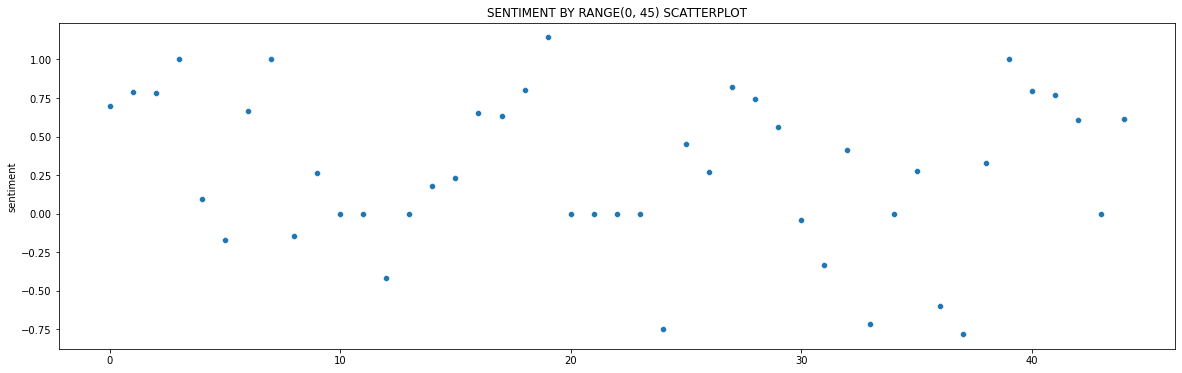

'here we have the shape of the distribution of each feature at a given point in the \ny dimension, in this case at a certain charge.  You can estimate the correlation between the\ndata of the given features based on their visual relation to each other!'

In [ ]:
visualize_dataframe(journal_with_sentiments_df_clean, range(journal_with_sentiments_df_clean.shape[0]), "sentiment", "scatter")

'''here we have the shape of the distribution of each feature at a given point in the 
y dimension, in this case at a certain charge.  You can estimate the correlation between the
data of the given features based on their visual relation to each other!'''

In [ ]:
'''you can estimate from the violinplot that the more homogeneous the datapoints at a given
point on the y axis, the flatter the distribution curve. Theoretically if the datapoints were 
100% homogenous at a certain space on the y-axis, then an acutal curve shape would not exist,
but rather a line shape'''

'you can estimate from the violinplot that the more homogeneous the datapoints at a given\npoint on the y axis, the flatter the distribution curve. Theoretically if the datapoints were \n100% homogenous at a certain space on the y-axis, then an acutal curve shape would not exist,\nbut rather a line shape'

##3. Data Preparation

##4. Modeling

## 5. Evaluation

##6. Deployment

